In [2]:
import numpy as np
import os
import imageio # To imread and imresize
import datetime
from PIL import Image # To imread and imresize
import matplotlib.pyplot as plt

from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, GRU, Flatten, TimeDistributed, BatchNormalization, Activation,Dropout
from keras.layers import Conv3D, MaxPooling3D, MaxPooling2D

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

from keras.applications.vgg16 import VGG16
from keras.applications import mobilenet
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD

In [4]:
import gc
from keras import backend as K
#gc.collect() 
K.clear_session()

In [ ]:
import os
import zipfile

def zip_folders_with_prefix(directory, prefix):
    # Get a list of all directories in the current directory
    folders = [f for f in os.listdir(directory) if os.path.isdir(os.path.join(directory, f)) and f.startswith(prefix)]
    
    # Iterate over each directory and zip its contents
    for folder in folders:
        folder_path = os.path.join(directory, folder)
        zip_filename = f"{folder}.zip"
        with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
            # Walk through the directory tree and add files to the zip file
            for root, dirs, files in os.walk(folder_path):
                for file in files:
                    file_path = os.path.join(root, file)
                    # Write the file to the zip file, preserving the directory structure
                    zipf.write(file_path, os.path.relpath(file_path, folder_path))

#if __name__ == "__main__":
#    current_directory = os.getcwd()  # Get the current directory
#    folder_prefix = "model"  # Specify the prefix of the folders to be zipped
#    zip_folders_with_prefix(current_directory, folder_prefix)


In [5]:
# We set the random seed so that the results don't vary drastically.
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In [6]:
path = "/datasets/Project_data"

In [7]:
folder_name ="/datasets/Project_data" 
train_doc = np.random.permutation(open(folder_name + '/train.csv').readlines())
val_doc = np.random.permutation(open(folder_name + '/val.csv').readlines())
batch_size = 64     #experiment with the batch size

In [8]:
def plot(history):
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(num_epochs)
    plt.figure(figsize=(15, 7))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title('Training and Validation Accuracy')
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

In [9]:
# Let us save each model epochs in a directory by making check points and also save the model metrics (training accuracy, traing loss ,validation loss, validation accuracy)
def callback_directory(curr_dt_time):
  model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
  if not os.path.exists(model_name):
    os.mkdir(model_name)
        
  filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

  checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

  LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0.00001)
  callbacks_list = [checkpoint, LR]
  return callbacks_list

In [10]:
# Normalize the image by dividing the pixel values by 255 which resuilts the values range from 0 to 1
def normalise1(image):
  return image/255.

def generator(source_path, folder_list, batch_size,y,z,normalise):
    print( 'Source path = ', source_path, '; batch size =', batch_size,';Image resolution = ({},{})'.format(y,z))
    img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29] #create a list of image numbers you want to use for a particular video
    # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
    x=len(img_idx)
    while True:
        t = np.random.permutation(folder_list)
        num_batches =  int(len(t)/batch_size)  # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = Image.open(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item])
                  
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes

                    if(image.size[0] == 160): # crop the image of shape 120 X 160 to make it  120 X120
                      image = image.crop((20,0,140,120)) # left =20, top =0, right = 140, bottom = 120
                    
                    image = image.resize(size = (y,z)) #imageio.imresize(image,(y,z)).astype(np.float32)
                    image = np.asarray(image).astype(np.float32)

                    batch_data[folder,idx,:,:,0] = normalise(image[:,:,0])  #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = normalise(image[:,:,1]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = normalise(image[:,:,2]) #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches

        if (len(t) % batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,x,y,z,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = Image.open(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item])
                    if image.size[0] == 160:
                        image = image.crop((20,0,140,120)) # left =20, top =0, right = 140, bottom = 120
                    
                    image = image.resize(size = (y,z)) 
                    image = np.asarray(image).astype(np.float32)

                    
                    batch_data[folder,idx,:,:,0] = normalise(image[:,:,0])  #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = normalise(image[:,:,1]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = normalise(image[:,:,2]) #normalise and feed in the image

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

In [11]:
imgs = os.listdir(folder_name+'/train/'+ train_doc[0].split(';')[0]) # read a sample sequence of images (a video) from the folder
image = imageio.imread(folder_name+'/train/'+ train_doc[0].strip().split(';')[0]+'/'+imgs[0]).astype(np.float32)
#image

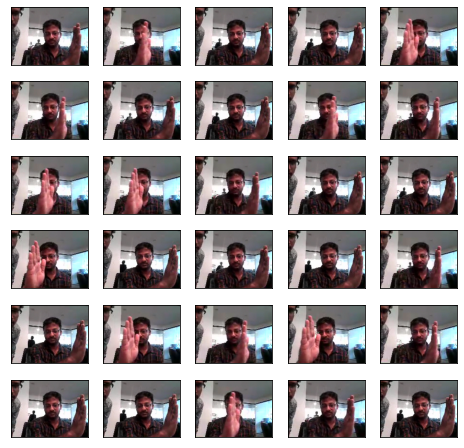

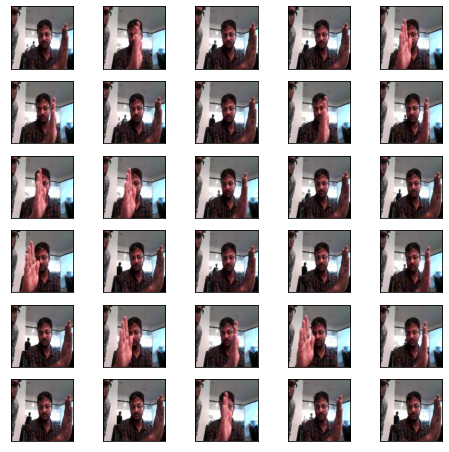

In [12]:
import matplotlib.pyplot as plt

from PIL import Image

imgs = os.listdir(folder_name+'/train/'+ train_doc[0].split(';')[0]) # read a sample sequence of images (a video) from the folder
plt.figure(figsize=(8,8))
for item in range(len(imgs)): #  Iterate over the frames/images of a folder to read them in
  im = Image.open(folder_name+'/train/'+ train_doc[0].split(';')[0] +"/"+ imgs[item])
  im = np.asarray(im)
  plt.subplot(6,5,item+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(im)
 
plt.show()
#print(im.shape)
#print('***********************After Resize*******************************************')
plt.figure(figsize=(8,8))
for item in range (len(imgs)):
  im = Image.open(folder_name + '/train/' + train_doc[0].split(';')[0] + '/' + imgs[item])
  im = im.resize(size =(100,100))
  im = np.asarray(im)
  plt.subplot(6,5,item+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(im)

#print(im.shape)
  

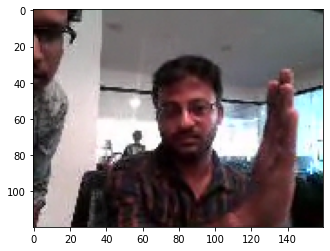

In [13]:
im = Image.open(folder_name + '/train/' + train_doc[0].split(';')[0] + '/' + imgs[0])
plt.imshow(im)

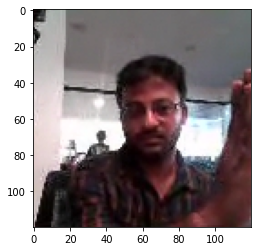

In [14]:
# Crop the sample image
width, height =im.size
left = 20
top = 0
right = width - 20 
bottom = height
im = np.array(im.crop((left,top,right,bottom)))
plt.imshow(im)

In [15]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation,Dropout
from keras.layers import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

def Conv3dArchitecture(x,y,z):
  conv3d_model = Sequential()
  conv3d_model.add(Conv3D(64, (3,3,3), strides=(1,1,1), padding='same', input_shape=(x,y,z,3)))
  conv3d_model.add(BatchNormalization())
  conv3d_model.add(Activation('relu'))
  conv3d_model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

  conv3d_model.add(Conv3D(128, (3,3,3), strides=(1,1,1), padding='same'))
  conv3d_model.add(BatchNormalization())
  conv3d_model.add(Activation('relu'))
  conv3d_model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))


  conv3d_model.add(Conv3D(256, (3,3,3), strides=(1,1,1), padding='same'))
  conv3d_model.add(BatchNormalization())
  conv3d_model.add(Activation('relu'))
  conv3d_model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))


  conv3d_model.add(Conv3D(256, (3,3,3), strides=(1,1,1), padding='same'))
  conv3d_model.add(BatchNormalization())
  conv3d_model.add(Activation('relu'))
  conv3d_model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

  conv3d_model.add(Flatten())
  conv3d_model.add(Dropout(0.5))
  conv3d_model.add(Dense(512, activation='relu'))
  conv3d_model.add(Dropout(0.5))
  conv3d_model.add(Dense(5, activation='softmax'))
  return conv3d_model

In [16]:
import tensorflow as tf

sgd = tf.keras.optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.7, nesterov=True)

# Using sgd optimizer
#from keras import optimizers
#from keras.optimizers import legacy
#sgd = optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.7, nesterov=True)
img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29]
x=len(img_idx)
y = 100
z = 100
conv3d_model = Conv3dArchitecture(x,y,z)
conv3d_model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (conv3d_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 18, 100, 100, 64)  5248      
                                                                 
 batch_normalization (BatchN  (None, 18, 100, 100, 64)  256      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 18, 100, 100, 64)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 9, 50, 50, 64)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 9, 50, 50, 128)    221312    
                                                                 
 batch_normalization_1 (Batc  (None, 9, 50, 50, 128)   5

2024-05-02 11:22:24.725268: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-05-02 11:22:24.725330: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14800 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1c:00.0, compute capability: 7.5


In [17]:
# Just to check the file name format
import datetime as dt
curr_dt_time = dt.datetime.now()
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
print(curr_dt_time)
print(model_name)


2024-05-02 11:22:29.228317
model_init_2024-05-0211_22_29.228317/


In [18]:
# Set the time to give unique filename to each checkpoint
import datetime 
curr_dt_time = datetime.datetime.now()
train_path = '/datasets/Project_data/train'
val_path =  '/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


In [19]:
# Let us save each model epochs in a directory by making check points and also save the model metrics (training accuracy, traing loss ,validation loss, validation accuracy)
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [checkpoint, LR]

In [20]:
# Assign the number of steps per epoch for training and validation dataset
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [19]:
# Count the sample dataset for each class
num =list(map(lambda x : x.replace('\n','')[-1], train_doc))
print(num.count('0'))
print(num.count('1'))
print(num.count('2'))
print(num.count('3'))
print(num.count('4'))

136
137
130
137
123


In [20]:
# Let us create the train_generator and the val_generator which will be used in .fit_generator.

batch_size = 16
y = 100 # (y,z) is the Image resolution 
z = 100
normalise = lambda a: a/255.
train_generator = generator(train_path, train_doc[0:160], batch_size,y,z,normalise)
val_generator = generator(val_path, val_doc[0:40], batch_size,y,z,normalise)
num_epochs = 2

history = conv3d_model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /datasets/Project_data/train ; batch size = 16 ;Image resolution = (100,100)
Epoch 1/2


2024-05-02 07:35:43.531665: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


11/11 [==============================] - ETA: 0s - loss: 4.3544 - categorical_accuracy: 0.2557Source path =  /datasets/Project_data/val ; batch size = 16 ;Image resolution = (100,100)

Epoch 00001: val_loss improved from inf to 1.55562, saving model to model_init_2024-05-0207_35_23.863184/model-00001-4.35441-0.25568-1.55562-0.18750.h5
11/11 [==============================] - 38s 3s/step - loss: 4.3544 - categorical_accuracy: 0.2557 - val_loss: 1.5556 - val_categorical_accuracy: 0.1875 - lr: 0.0010
Epoch 2/2
11/11 [==============================] - ETA: 0s - loss: 2.3442 - categorical_accuracy: 0.3295
Epoch 00002: val_loss did not improve from 1.55562
11/11 [==============================] - 11s 1s/step - loss: 2.3442 - categorical_accuracy: 0.3295 - val_loss: 1.5806 - val_categorical_accuracy: 0.2812 - lr: 0.0010


In [22]:
#!ls /datasets/Project_data/train
import gc
from keras import backend as K
gc.collect() 
K.clear_session()
train_generator = None
val_generator = None
callbacks_list = None
steps_per_epoch = None
num_epochs = None
validation_steps = None

In [71]:
print(history)

In [72]:
print(history.history['loss'])
print(history.history['categorical_accuracy'])
print(history.history['val_loss'])
print(history.history['val_categorical_accuracy'])

[4.3237199783325195, 2.168288230895996]
[0.25, 0.4488636255264282]
[1.5649504661560059, 1.6485090255737305]
[0.3125, 0.125]


In [23]:
# Let us save each model epochs in a directory by making check points and also save the model metrics (training accuracy, traing loss ,validation loss, validation accuracy)
def callback_directory(curr_dt_time):
  model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
  if not os.path.exists(model_name):
    os.mkdir(model_name)
        
  filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

  checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

  LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0.00001)
  callbacks_list = [checkpoint, LR]
  return callbacks_list

In [24]:
# Set the time to give unique filename to each checkpoint
curr_dt_time = datetime.datetime.now()

num_epochs = 20 # choose the number of epochs
batch_size = 32

# Set the training and validation data set path
train_path = '/datasets/Project_data/train'
val_path = '/datasets/Project_data/val'

# Set the Number of training and validation sequence in dataset
num_train_sequences = len(train_doc)
num_val_sequences = len(val_doc)

img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29]
x=len(img_idx) # Number of images in sequence
y = 100
z = 100

In [25]:
# Compile the conv3d_model
# Using sgd optimizer
sgd = tf.keras.optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.7, nesterov=True)

#sgd = optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.7, nesterov=True)
conv3d_model1 = Conv3dArchitecture(x,y,z)
conv3d_model1.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(conv3d_model1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 18, 100, 100, 64)  5248      
                                                                 
 batch_normalization (BatchN  (None, 18, 100, 100, 64)  256      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 18, 100, 100, 64)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 9, 50, 50, 64)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 9, 50, 50, 128)    221312    
                                                                 
 batch_normalization_1 (Batc  (None, 9, 50, 50, 128)   5

In [26]:

# Call the file path creating callback_dirctory function 
callback_directory(curr_dt_time)

# Assign the number of steps per epoch for training and validation dataset
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1


# Let us create the train_generator and the val_generator which will be used in .fit_generator.

normalise = lambda a: a/255.
train_generator = generator(train_path, train_doc, batch_size,y,z,normalise)
val_generator = generator(val_path, val_doc, batch_size,y,z,normalise)


#Fit the model
history_model1 = conv3d_model1.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /datasets/Project_data/train ; batch size = 32 ;Image resolution = (100,100)
Epoch 1/20
21/21 [==============================] - 100s 5s/step - loss: 2.9372 - categorical_accuracy: 0.3137 - val_loss: 1.6272 - val_categorical_accuracy: 0.2200
Epoch 2/20
21/21 [==============================] - 41s 2s/step - loss: 1.6317 - categorical_accuracy: 0.4284 - val_loss: 1.8409 - val_categorical_accuracy: 0.2400
Epoch 3/20
21/21 [==============================] - 40s 2s/step - loss: 1.2796 - categorical_accuracy: 0.5053 - val_loss: 2.4434 - val_categorical_accuracy: 0.2000
Epoch 4/20
21/21 [==============================] - 38s 2s/step - loss: 1.2833 - categorical_accuracy: 0.4842 - val_loss: 2.4488 - val_categorical_accuracy: 0.2200
Epoch 5/20
21/21 [==============================] - 39s 2s/step - loss: 1.1152 - categorical_accuracy: 0.5505 - val_loss: 2.8604 - val_categorical_accuracy: 0.2200
Epoch 6/20
21/21 [==============================] - 39s 2s/step - loss: 1.0032 - catego

In [ ]:
!ls '/datasets'
gc.collect() 
K.clear_session()
train_generator = None
val_generator = None
callbacks_list = None
steps_per_epoch = None
num_epochs = None
validation_steps = None

In [30]:
# Set the time to give unique filename to each checkpoint
curr_dt_time = datetime.datetime.now()

num_epochs = 20 # choose the number of epochs
batch_size = 32

# Set the training and validation data set path
train_path = folder_name+'/train/'# '/dataset/Project_data/train'
val_path = folder_name+'/val/'# '/dataset/Project_data/val'

# Set the Number of training and validation sequence in dataset
num_train_sequences = len(train_doc)
num_val_sequences = len(val_doc)

img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29]
x=len(img_idx) # Number of images in sequence
y = 80
z = 80

In [31]:
# Compile the conv3d_model
# Using sgd optimizer
#sgd = optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.7, nesterov=True)
sgd = tf.keras.optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.7, nesterov=True)

conv3d_model1 = Conv3dArchitecture(x,y,z)
conv3d_model1.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(conv3d_model1.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 18, 80, 80, 64)    5248      
                                                                 
 batch_normalization_8 (Batc  (None, 18, 80, 80, 64)   256       
 hNormalization)                                                 
                                                                 
 activation_8 (Activation)   (None, 18, 80, 80, 64)    0         
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 9, 40, 40, 64)    0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 9, 40, 40, 128)    221312    
                                                                 
 batch_normalization_9 (Batc  (None, 9, 40, 40, 128)  

In [32]:
# Call the file path creating callback_dirctory function 
callback_directory(curr_dt_time)

# Assign the number of steps per epoch for training and validation dataset
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1


# Let us create the train_generator and the val_generator which will be used in .fit_generator.

normalise = lambda a: a/255.
train_generator = generator(train_path, train_doc, batch_size,y,z,normalise)
val_generator = generator(val_path, val_doc, batch_size,y,z,normalise)


#Fit the model
history_model1 = conv3d_model1.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /datasets/Project_data/train/ ; batch size = 32 ;Image resolution = (80,80)
Epoch 1/20
21/21 [==============================] - 38s 2s/step - loss: 2.9142 - categorical_accuracy: 0.3032 - val_loss: 1.6326 - val_categorical_accuracy: 0.2500
Epoch 2/20
21/21 [==============================] - 36s 2s/step - loss: 1.7328 - categorical_accuracy: 0.4178 - val_loss: 1.9308 - val_categorical_accuracy: 0.1400
Epoch 3/20
21/21 [==============================] - 37s 2s/step - loss: 1.5006 - categorical_accuracy: 0.4525 - val_loss: 2.4007 - val_categorical_accuracy: 0.1400
Epoch 4/20
21/21 [==============================] - 35s 2s/step - loss: 1.2515 - categorical_accuracy: 0.5189 - val_loss: 2.7204 - val_categorical_accuracy: 0.1600
Epoch 5/20
21/21 [==============================] - 37s 2s/step - loss: 1.0731 - categorical_accuracy: 0.5490 - val_loss: 3.0919 - val_categorical_accuracy: 0.1600
Epoch 6/20
21/21 [==============================] - 37s 2s/step - loss: 1.0910 - categori

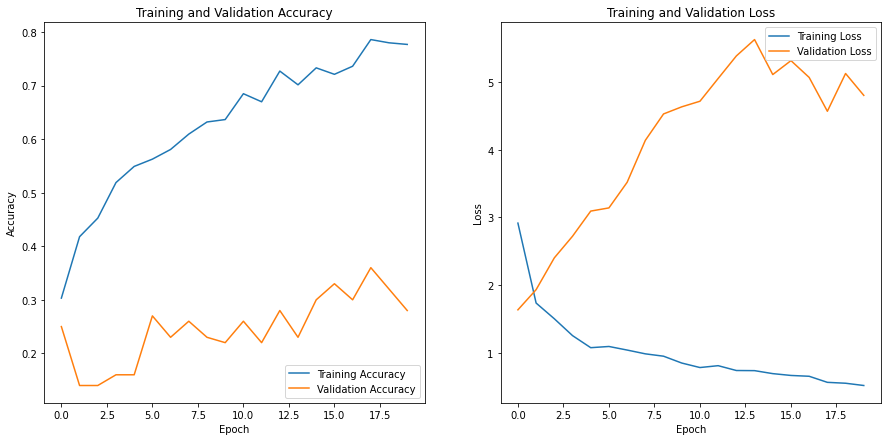

In [33]:
# Visualizing the model accuracy and loss
# 
acc = history_model1.history['categorical_accuracy']
val_acc = history_model1.history['val_categorical_accuracy']

loss = history_model1.history['loss']
val_loss = history_model1.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [34]:
gc.collect() 

9903

In [35]:
K.clear_session()

In [36]:
# Set the time to give unique filename to each checkpoint
curr_dt_time = datetime.datetime.now()

num_epochs = 20 # choose the number of epochs
batch_size = 16

# Set the training and validation data set path
train_path = '/datasets/Project_data/train'
val_path = '/datasets/Project_data/val'

# Set the Number of training and validation sequence in dataset
num_train_sequences = len(train_doc)
num_val_sequences = len(val_doc)

img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29]
x=len(img_idx) # Number of images in sequence
y = 80
z = 80

In [37]:
# Compile the conv3d_model
# Using sgd optimizer
#sgd = optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.7, nesterov=True)
sgd = tf.keras.optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.7, nesterov=True)

conv3d_model1 = Conv3dArchitecture(x,y,z)
conv3d_model1.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(conv3d_model1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 18, 80, 80, 64)    5248      
                                                                 
 batch_normalization (BatchN  (None, 18, 80, 80, 64)   256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 18, 80, 80, 64)    0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 9, 40, 40, 64)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 9, 40, 40, 128)    221312    
                                                                 
 batch_normalization_1 (Batc  (None, 9, 40, 40, 128)   5

In [38]:
# Call the file path creating callback_dirctory function 
callback_directory(curr_dt_time)

# Assign the number of steps per epoch for training and validation dataset
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1


# Let us create the train_generator and the val_generator which will be used in .fit_generator.

normalise = lambda a: a/255.
train_generator = generator(train_path, train_doc, batch_size,y,z,normalise)
val_generator = generator(val_path, val_doc, batch_size,y,z,normalise)


#Fit the model
history_model1 = conv3d_model1.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /datasets/Project_data/train ; batch size = 16 ;Image resolution = (80,80)
Epoch 1/20
42/42 [==============================] - 37s 860ms/step - loss: 2.7724 - categorical_accuracy: 0.3213 - val_loss: 1.9670 - val_categorical_accuracy: 0.2100
Epoch 2/20
42/42 [==============================] - 35s 857ms/step - loss: 1.7112 - categorical_accuracy: 0.3922 - val_loss: 2.5015 - val_categorical_accuracy: 0.1600
Epoch 3/20
42/42 [==============================] - 35s 846ms/step - loss: 1.3616 - categorical_accuracy: 0.4585 - val_loss: 2.9723 - val_categorical_accuracy: 0.1800
Epoch 4/20
42/42 [==============================] - 35s 857ms/step - loss: 1.2546 - categorical_accuracy: 0.4842 - val_loss: 3.5856 - val_categorical_accuracy: 0.2400
Epoch 5/20
42/42 [==============================] - 35s 844ms/step - loss: 1.0505 - categorical_accuracy: 0.5716 - val_loss: 4.1335 - val_categorical_accuracy: 0.1400
Epoch 6/20
42/42 [==============================] - 36s 871ms/step - loss: 

In [43]:
#gc.collect() 
K.clear_session()

In [44]:
# Set the time to give unique filename to each checkpoint
curr_dt_time = datetime.datetime.now()

num_epochs = 30 # choose the number of epochs
batch_size = 32

# Set the training and validation data set path
train_path = '/datasets/Project_data/train'
val_path = '/datasets/Project_data/val'

# Set the Number of training and validation sequence in dataset
num_train_sequences = len(train_doc)
num_val_sequences = len(val_doc)

img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29]
x=len(img_idx) # Number of images in sequence
y = 100
z = 100

In [45]:
# Compile the conv3d_model
# Using sgd optimizer
#sgd = optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.7, nesterov=True)
sgd = tf.keras.optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.7, nesterov=True)

conv3d_model1 = Conv3dArchitecture(x,y,z)
conv3d_model1.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(conv3d_model1.summary())

# Call the file path creating callback_dirctory function 
callback_directory(curr_dt_time)

# Assign the number of steps per epoch for training and validation dataset
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 18, 100, 100, 64)  5248      
                                                                 
 batch_normalization (BatchN  (None, 18, 100, 100, 64)  256      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 18, 100, 100, 64)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 9, 50, 50, 64)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 9, 50, 50, 128)    221312    
                                                                 
 batch_normalization_1 (Batc  (None, 9, 50, 50, 128)   5

In [46]:
# Let us create the train_generator and the val_generator which will be used in .fit.

normalise = lambda a: a/255.
train_generator = generator(train_path, train_doc, batch_size,y,z,normalise)
val_generator = generator(val_path, val_doc, batch_size,y,z,normalise)


#Fit the model
history_model1 = conv3d_model1.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Source path =  /datasets/Project_data/train ; batch size = 32 ;Image resolution = (100,100)
Epoch 1/30
21/21 [==============================] - 41s 2s/step - loss: 2.9172 - categorical_accuracy: 0.2896 - val_loss: 1.6243 - val_categorical_accuracy: 0.2200
Epoch 2/30
21/21 [==============================] - 39s 2s/step - loss: 1.7311 - categorical_accuracy: 0.4042 - val_loss: 1.9282 - val_categorical_accuracy: 0.2100
Epoch 3/30
21/21 [==============================] - 40s 2s/step - loss: 1.3472 - categorical_accuracy: 0.4872 - val_loss: 2.3202 - val_categorical_accuracy: 0.1700
Epoch 4/30
21/21 [==============================] - 38s 2s/step - loss: 1.3173 - categorical_accuracy: 0.4827 - val_loss: 2.4213 - val_categorical_accuracy: 0.2200
Epoch 5/30
21/21 [==============================] - 39s 2s/step - loss: 1.1629 - categorical_accuracy: 0.5279 - val_loss: 2.7719 - val_categorical_accuracy: 0.2300
Epoch 6/30
21/21 [==============================] - 40s 2s/step - loss: 1.0516 - categor

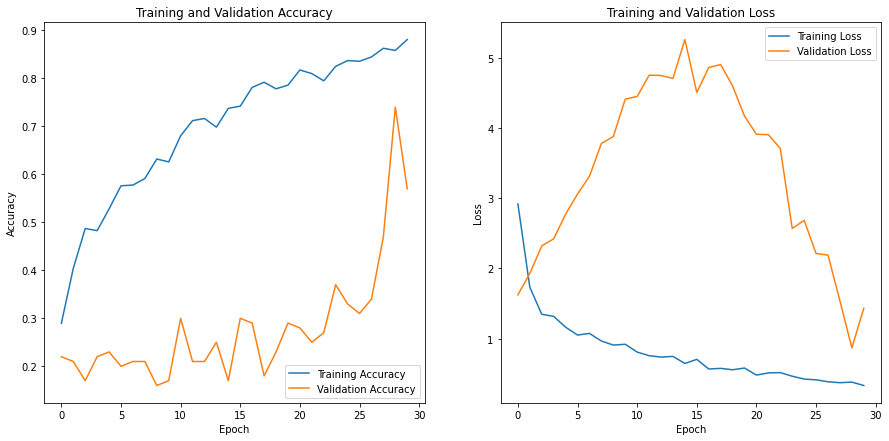

In [47]:
# 
acc = history_model1.history['categorical_accuracy']
val_acc = history_model1.history['val_categorical_accuracy']

loss = history_model1.history['loss']
val_loss = history_model1.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [48]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation,Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

def conv3d_architecture1(x,y,z):
  conv3d_model = Sequential()
  conv3d_model.add(Conv3D(32, (3,3,3), strides=(1,1,1), padding='same', input_shape=(x,y,z,3)))
  conv3d_model.add(BatchNormalization())
  conv3d_model.add(Activation('relu'))
  conv3d_model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

  conv3d_model.add(Conv3D(64, (3,3,3), strides=(1,1,1), padding='same'))
  conv3d_model.add(BatchNormalization())
  conv3d_model.add(Activation('relu'))
  conv3d_model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))


  conv3d_model.add(Conv3D(128, (3,3,3), strides=(1,1,1), padding='same'))
  conv3d_model.add(BatchNormalization())
  conv3d_model.add(Activation('relu'))
  conv3d_model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))
  
  conv3d_model.add(Conv3D(128, (3,3,3), strides=(1,1,1), padding='same'))
  conv3d_model.add(BatchNormalization())
  conv3d_model.add(Activation('relu'))
  conv3d_model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

  conv3d_model.add(Flatten())
  conv3d_model.add(Dropout(0.5))
  conv3d_model.add(Dense(256, activation='relu'))
  conv3d_model.add(Dropout(0.5))
  conv3d_model.add(Dense(5, activation='softmax'))
  return conv3d_model

In [49]:
def cnn_lstm(x,y,z):
  base_model = VGG16(include_top=False, weights='imagenet', input_shape=(y,z,3))
  a = base_model.output
  a = Flatten()(a)
  features = Dense(64, activation='relu')(a)
  conv_model = Model(inputs=base_model.input, outputs=features)
    
  for layer in base_model.layers:
      layer.trainable = False
        
  model = Sequential()
  model.add(TimeDistributed(conv_model, input_shape=(x,y,z,3)))

  model.add(LSTM(64, return_sequences=True))
  model.add(LSTM(32))

  model.add(Dense(8, activation='relu'))
  model.add(Dense(5, activation='softmax'))
  return model


In [50]:
# Set the time to give unique filename to each checkpoint
curr_dt_time = datetime.datetime.now()
num_epochs = 30 # choose the number of epochs
batch_size = 32
img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29]
x=len(img_idx) # Number of images in sequence
y = 100
z = 100

# Set the training and validation data set path
train_path = '/datasets/Project_data/train'
val_path = '/datasets/Project_data/val'

# Set the Number of training and validation sequence in dataset
num_train_sequences = len(train_doc)
num_val_sequences = len(val_doc)

# Assign the number of steps per epoch for training and validation dataset
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [51]:
# Compile the conv3d_model
# Using sgd optimizer

#sgd = optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.7, nesterov=True)
sgd = tf.keras.optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.7, nesterov=True)

model5 = cnn_lstm(x,y,z)
model5.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model5.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 18, 64)           15009664  
 ibuted)                                                         
                                                                 
 lstm (LSTM)                 (None, 18, 64)            33024     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense_3 (Dense)             (None, 8)                 264       
                                                                 
 dense_4 (Dense)             (None, 5)                 45        
                                                                 
Total params: 15,055,413
Trainable params: 340,725
Non-trainable params: 14,714,688
____________________________________

In [52]:
# Call the file path creating callback_dirctory function 

callbacks_list = callback_directory(curr_dt_time)

# Let us create the train_generator and the val_generator which will be used in .fit_generator.

normalise = lambda a: a/255.
train_generator = generator(train_path, train_doc, batch_size,y,z,normalise)
val_generator = generator(val_path, val_doc, batch_size,y,z,normalise)

In [53]:
#Fit the model
history_model5 = model5.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /datasets/Project_data/train ; batch size = 32 ;Image resolution = (100,100)
Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 1.6351 - categorical_accuracy: 0.2006Source path =  /datasets/Project_data/val ; batch size = 32 ;Image resolution = (100,100)

Epoch 00001: val_loss improved from inf to 1.60072, saving model to model_init_2024-05-0208_57_20.315827/model-00001-1.63508-0.20060-1.60072-0.22000.h5
21/21 [==============================] - 48s 2s/step - loss: 1.6351 - categorical_accuracy: 0.2006 - val_loss: 1.6007 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 1.6066 - categorical_accuracy: 0.1931
Epoch 00002: val_loss improved from 1.60072 to 1.60026, saving model to model_init_2024-05-0208_57_20.315827/model-00002-1.60659-0.19306-1.60026-0.18000.h5
21/21 [==============================] - 40s 2s/step - loss: 1.6066 - categorical_accuracy: 0.1931 - val_loss: 1.6003 - val_categori

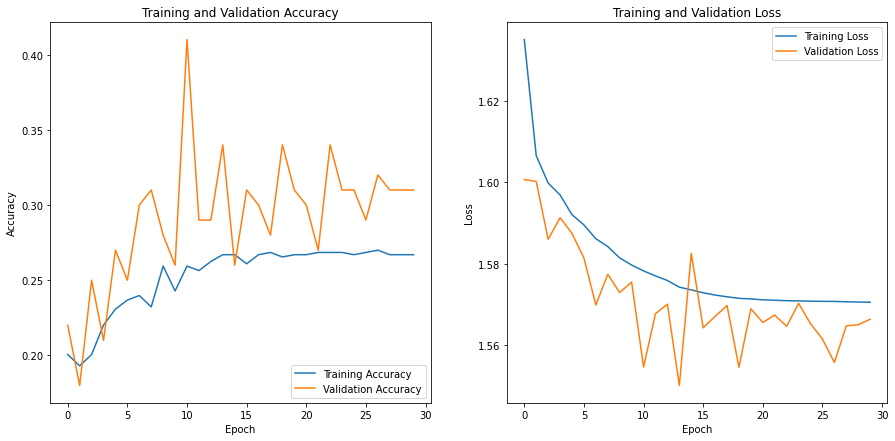

In [54]:
plot(history_model5)

In [55]:
def cnn_gru(x,y,z, dropout):
    
  base_model = VGG16(include_top=False, weights='imagenet', input_shape=(y,z,3))
  a = base_model.output
  a = Flatten()(a)
  features = Dense(64, activation='relu')(a)
  conv_model = Model(inputs=base_model.input, outputs=features)
    
  for layer in base_model.layers:
      layer.trainable = False
        
  model = Sequential()
  model.add(TimeDistributed(conv_model, input_shape=(x,y,z,3)))
  model.add(GRU(128, return_sequences=True))
  model.add(GRU(64))
  model.add(Dropout(dropout))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(5, activation='softmax'))
  return model

In [57]:
#gc.collect() 
K.clear_session()

In [58]:
# Set the time to give unique filename to each checkpoint
curr_dt_time = datetime.datetime.now()

num_epochs = 20 # choose the number of epochs
batch_size = 32

# Set the training and validation data set path
train_path = '/datasets/Project_data/train'
val_path = '/datasets/Project_data/val'

# Set the Number of training and validation sequence in dataset
num_train_sequences = len(train_doc)
num_val_sequences = len(val_doc)

img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29]
x=len(img_idx) # Number of images in sequence
y = 100
z = 100

# Assign the number of steps per epoch for training and validation dataset
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1



In [59]:
help(optimizers)

Help on module keras.optimizers in keras:

NAME
    keras.optimizers - Built-in optimizer classes.

DESCRIPTION
    For more examples see the base class `tf.keras.optimizers.Optimizer`.

FUNCTIONS
    deserialize(config, custom_objects=None)
        Inverse of the `serialize` function.
        
        Args:
            config: Optimizer configuration dictionary.
            custom_objects: Optional dictionary mapping names (strings) to custom
              objects (classes and functions) to be considered during deserialization.
        
        Returns:
            A Keras Optimizer instance.
    
    get(identifier)
        Retrieves a Keras Optimizer instance.
        
        Args:
            identifier: Optimizer identifier, one of
                - String: name of an optimizer
                - Dictionary: configuration dictionary. - Keras Optimizer instance (it
                  will be returned unchanged). - TensorFlow Optimizer instance (it
                  will be wrapped a

In [60]:
# Compile the conv3d_model
from tensorflow.keras.optimizers import Adam

adam = Adam(learning_rate=0.0001)
# Using Adam optimizer
#adam = optimizers.Adam(learning_rate=0.0001)
#adam = optimizers.Adam()
model6 = cnn_gru(x,y,z,0.25)
model6.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model6.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 18, 64)           15009664  
 ibuted)                                                         
                                                                 
 gru (GRU)                   (None, 18, 128)           74496     
                                                                 
 gru_1 (GRU)                 (None, 64)                37248     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 5)                 325       
                                                        

In [61]:
# Call the file path creating callback_dirctory function 
callbacks_list = callback_directory(curr_dt_time)


# Let us create the train_generator and the val_generator which will be used in .fit_generator.

normalise = lambda a: a/255.
train_generator = generator(train_path, train_doc, batch_size,y,z,normalise)
val_generator = generator(val_path, val_doc, batch_size,y,z,normalise)

In [62]:
#Fit the model
history_model6 = model6.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /datasets/Project_data/train ; batch size = 32 ;Image resolution = (100,100)
Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 1.6106 - categorical_accuracy: 0.2187Source path =  /datasets/Project_data/val ; batch size = 32 ;Image resolution = (100,100)

Epoch 00001: val_loss improved from inf to 1.56740, saving model to model_init_2024-05-0209_54_39.558919/model-00001-1.61061-0.21870-1.56740-0.34000.h5
21/21 [==============================] - 57s 3s/step - loss: 1.6106 - categorical_accuracy: 0.2187 - val_loss: 1.5674 - val_categorical_accuracy: 0.3400 - lr: 1.0000e-04
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.5448 - categorical_accuracy: 0.3273
Epoch 00002: val_loss improved from 1.56740 to 1.49138, saving model to model_init_2024-05-0209_54_39.558919/model-00002-1.54478-0.32730-1.49138-0.49000.h5
21/21 [==============================] - 41s 2s/step - loss: 1.5448 - categorical_accuracy: 0.3273 - val_loss: 1.4914 - val_cate

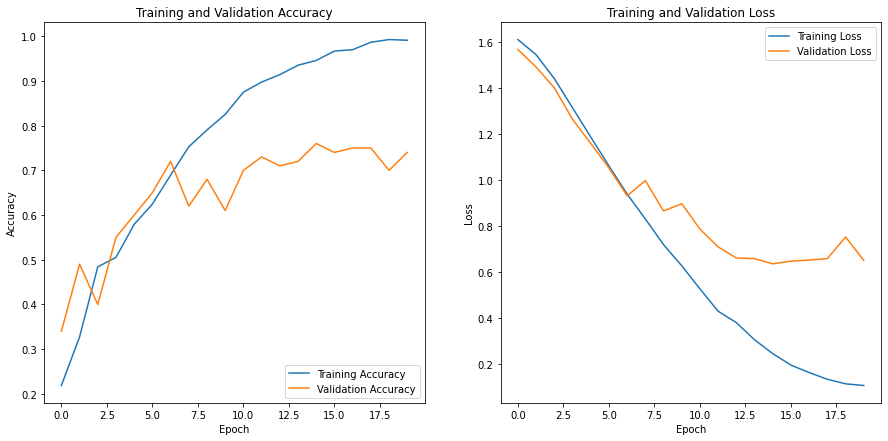

In [63]:
plot(history_model6)

In [64]:
#adam = optimizers.Adam(learning_rate=0.0001)
adam = Adam(learning_rate=0.0001)
model6_2 = cnn_gru(x,y,z, 0.25)
model6_2.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model6_2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_1 (TimeDis  (None, 18, 64)           15009664  
 tributed)                                                       
                                                                 
 gru_2 (GRU)                 (None, 18, 128)           74496     
                                                                 
 gru_3 (GRU)                 (None, 64)                37248     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 5)                 325       
                                                      

In [65]:
#Fit the model
num_epochs=20
history_model6_2 = model6_2.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 1.6040 - categorical_accuracy: 0.2323
Epoch 00001: val_loss did not improve from 0.63595
21/21 [==============================] - 88s 4s/step - loss: 1.6040 - categorical_accuracy: 0.2323 - val_loss: 1.5467 - val_categorical_accuracy: 0.3600 - lr: 1.0000e-04
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.5221 - categorical_accuracy: 0.3710
Epoch 00002: val_loss did not improve from 0.63595
21/21 [==============================] - 41s 2s/step - loss: 1.5221 - categorical_accuracy: 0.3710 - val_loss: 1.4778 - val_categorical_accuracy: 0.4700 - lr: 1.0000e-04
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss: 1.4026 - categorical_accuracy: 0.4992
Epoch 00003: val_loss did not improve from 0.63595
21/21 [==============================] - 39s 2s/step - loss: 1.4026 - categorical_accuracy: 0.4992 - val_loss: 1.3273 - val_categorical_accuracy: 0.6600 - lr: 1.0000e-04
Epoch 4/20
21/21 [=

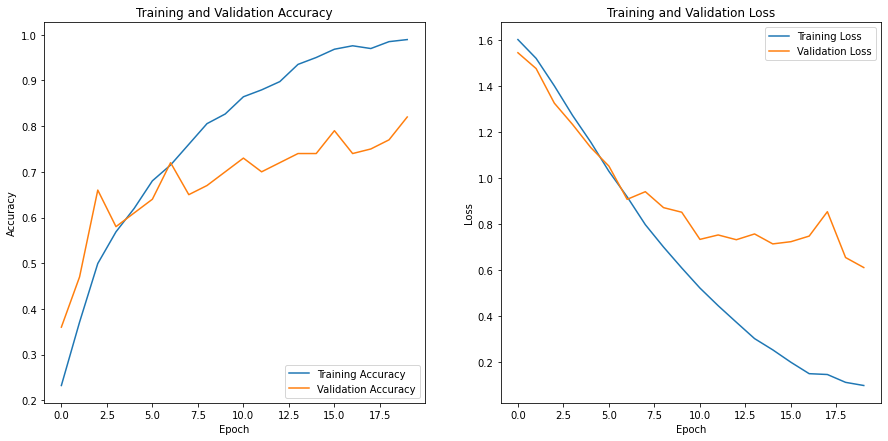

In [66]:
plot(history_model6_2)

In [67]:
#adam = optimizers.Adam(learning_rate=0.0001)
adam = Adam(learning_rate=0.0001)
model6_3 = cnn_gru(x,y,z, 0.5)
model6_3.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model6_3.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_2 (TimeDis  (None, 18, 64)           15009664  
 tributed)                                                       
                                                                 
 gru_4 (GRU)                 (None, 18, 128)           74496     
                                                                 
 gru_5 (GRU)                 (None, 64)                37248     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dense_8 (Dense)             (None, 5)                 325       
                                                      

In [68]:
#Fit the model
num_epochs=20
history_model6_3 = model6_3.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 1.6286 - categorical_accuracy: 0.2202
Epoch 00001: val_loss did not improve from 0.61149
21/21 [==============================] - 43s 2s/step - loss: 1.6286 - categorical_accuracy: 0.2202 - val_loss: 1.5772 - val_categorical_accuracy: 0.3200 - lr: 1.0000e-04
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.5688 - categorical_accuracy: 0.2881
Epoch 00002: val_loss did not improve from 0.61149
21/21 [==============================] - 40s 2s/step - loss: 1.5688 - categorical_accuracy: 0.2881 - val_loss: 1.5369 - val_categorical_accuracy: 0.3400 - lr: 1.0000e-04
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss: 1.5151 - categorical_accuracy: 0.3695
Epoch 00003: val_loss did not improve from 0.61149
21/21 [==============================] - 40s 2s/step - loss: 1.5151 - categorical_accuracy: 0.3695 - val_loss: 1.4866 - val_categorical_accuracy: 0.4800 - lr: 1.0000e-04
Epoch 4/20
21/21 [=

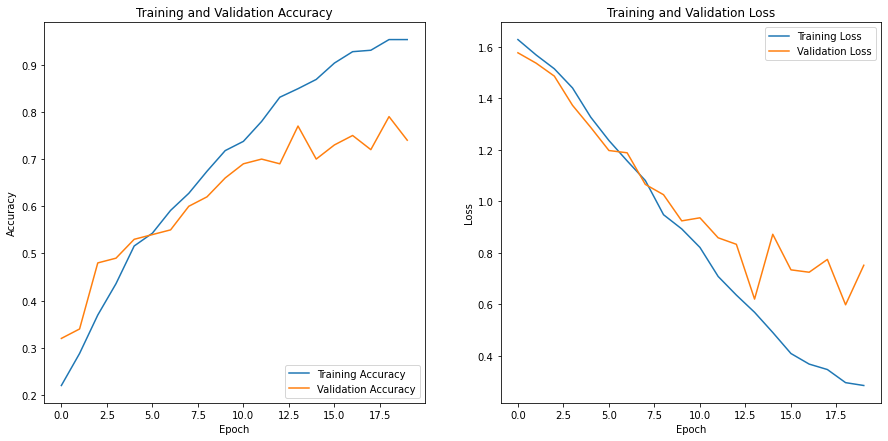

In [ ]:
plot(history_model6_3)

In [ ]:
def cnn_gru_4(x,y,z, dropout):
    
  base_model = VGG16(include_top=False, weights='imagenet', input_shape=(y,z,3))
  a = base_model.output
  a = Flatten()(a)
  features = Dense(64, activation='relu')(a)
  conv_model = Model(inputs=base_model.input, outputs=features)
    
  for layer in base_model.layers:
      layer.trainable = False
        
  model = Sequential()
  model.add(TimeDistributed(conv_model, input_shape=(x,y,z,3)))
  model.add(GRU(128, return_sequences=True))
  model.add(Dropout(dropout))
  model.add(GRU(64))
  model.add(Dropout(dropout))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(dropout))
  model.add(Dense(5, activation='softmax'))
  return model

In [ ]:
# Set the time to give unique filename to each checkpoint
curr_dt_time = datetime.datetime.now()

num_epochs = 15 # choose the number of epochs
batch_size = 32

# Set the training and validation data set path
train_path = '/datasets/Project_data/train'
val_path = '/datasets/Project_data/val'

# Set the Number of training and validation sequence in dataset
num_train_sequences = len(train_doc)
num_val_sequences = len(val_doc)

img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29]
x=len(img_idx) # Number of images in sequence
y = 100
z = 100

# Assign the number of steps per epoch for training and validation dataset
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
# Compile the conv3d_model
# Using Adam optimizer
adam = Adam(learning_rate=0.0001)
#adam = optimizers.Adam(learning_rate=0.0001)
model6_4 = cnn_gru_4(x,y,z,0.25)
model6_4.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model6_4.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_3 (TimeDis  (None, 18, 64)           15009664  
 tributed)                                                       
                                                                 
 gru_6 (GRU)                 (None, 18, 128)           74496     
                                                                 
 dropout_3 (Dropout)         (None, 18, 128)           0         
                                                                 
 gru_7 (GRU)                 (None, 64)                37248     
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 64)                4160      
                                                      

In [ ]:
# Call the file path creating callback_dirctory function 
callbacks_list = callback_directory(curr_dt_time)


# Let us create the train_generator and the val_generator which will be used in .fit_generator.

normalise = lambda a: a/255.
train_generator = generator(train_path, train_doc, batch_size,y,z,normalise)
val_generator = generator(val_path, val_doc, batch_size,y,z,normalise)

In [ ]:
#Fit the model
history_model6_4 = model6_4.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /datasets/Project_data/train ; batch size = 32 ;Image resolution = (100,100)
Epoch 1/15
21/21 [==============================] - ETA: 0s - loss: 1.6104 - categorical_accuracy: 0.1991Source path =  /datasets/Project_data/val ; batch size = 32 ;Image resolution = (100,100)

Epoch 00001: val_loss improved from inf to 1.57733, saving model to model_init_2024-05-0210_43_49.054882/model-00001-1.61042-0.19910-1.57733-0.19000.h5
21/21 [==============================] - 45s 2s/step - loss: 1.6104 - categorical_accuracy: 0.1991 - val_loss: 1.5773 - val_categorical_accuracy: 0.1900 - lr: 1.0000e-04
Epoch 2/15
21/21 [==============================] - ETA: 0s - loss: 1.5616 - categorical_accuracy: 0.2836
Epoch 00002: val_loss improved from 1.57733 to 1.53188, saving model to model_init_2024-05-0210_43_49.054882/model-00002-1.56160-0.28356-1.53188-0.48000.h5
21/21 [==============================] - 39s 2s/step - loss: 1.5616 - categorical_accuracy: 0.2836 - val_loss: 1.5319 - val_cate

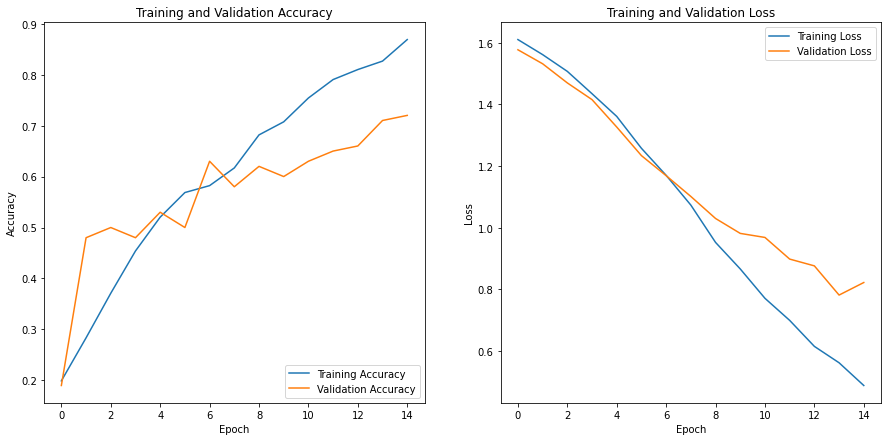

In [ ]:
plot(history_model6_4)

In [ ]:
def cnn_lstm_gru(x,y,z, dropout):
    
  base_model = VGG16(include_top=False, weights='imagenet', input_shape=(y,z,3))
  a = base_model.output
  a = Flatten()(a)
  features = Dense(64, activation='relu')(a)
  conv_model = Model(inputs=base_model.input, outputs=features)
    
  for layer in base_model.layers:
      layer.trainable = False
        
  model = Sequential()
  model.add(TimeDistributed(conv_model, input_shape=(x,y,z,3)))
  model.add(LSTM(128, return_sequences=True))
  model.add(GRU(64, return_sequences=True))
  model.add(GRU(32))
 
  model.add(Dense(64, activation='relu'))
  model.add(Dense(5, activation='softmax'))
  return model

In [ ]:
# Set the time to give unique filename to each checkpoint
curr_dt_time = datetime.datetime.now()
num_epochs = 20 # choose the number of epochs
batch_size = 32
img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29]
x=len(img_idx) # Number of images in sequence
y = 100
z = 100

# Set the training and validation data set path
train_path = '/datasets/Project_data/train'
val_path = '/datasets/Project_data/val'

# Set the Number of training and validation sequence in dataset
num_train_sequences = len(train_doc)
num_val_sequences = len(val_doc)

# Assign the number of steps per epoch for training and validation dataset
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
# Compile the conv3d_model
# Using Adam optimizer
adam = Adam(learning_rate=0.0001)
#adam = optimizers.Adam()
model7 = cnn_lstm_gru(x,y,z,.25)
model7.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model7.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_4 (TimeDis  (None, 18, 64)           15009664  
 tributed)                                                       
                                                                 
 lstm (LSTM)                 (None, 18, 128)           98816     
                                                                 
 gru_8 (GRU)                 (None, 18, 64)            37248     
                                                                 
 gru_9 (GRU)                 (None, 32)                9408      
                                                                 
 dense_13 (Dense)            (None, 64)                2112      
                                                                 
 dense_14 (Dense)            (None, 5)                 325       
                                                      

In [ ]:
# Call the file path creating callback_dirctory function 
callbacks_list = callback_directory(curr_dt_time)

# Let us create the train_generator and the val_generator which will be used in .fit_generator.

normalise = lambda a: a/255.
train_generator = generator(train_path, train_doc, batch_size,y,z,normalise)
val_generator = generator(val_path, val_doc, batch_size,y,z,normalise)

In [ ]:
#Fit the model
num_epochs=20
history_model7 = model7.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /datasets/Project_data/train ; batch size = 32 ;Image resolution = (100,100)
Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 1.5994 - categorical_accuracy: 0.2081Source path =  /datasets/Project_data/val ; batch size = 32 ;Image resolution = (100,100)

Epoch 00001: val_loss improved from inf to 1.57424, saving model to model_init_2024-05-0210_53_48.266174/model-00001-1.59936-0.20814-1.57424-0.25000.h5
21/21 [==============================] - 45s 2s/step - loss: 1.5994 - categorical_accuracy: 0.2081 - val_loss: 1.5742 - val_categorical_accuracy: 0.2500 - lr: 1.0000e-04
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.5349 - categorical_accuracy: 0.4163
Epoch 00002: val_loss improved from 1.57424 to 1.48957, saving model to model_init_2024-05-0210_53_48.266174/model-00002-1.53489-0.41629-1.48957-0.50000.h5
21/21 [==============================] - 39s 2s/step - loss: 1.5349 - categorical_accuracy: 0.4163 - val_loss: 1.4896 - val_cate

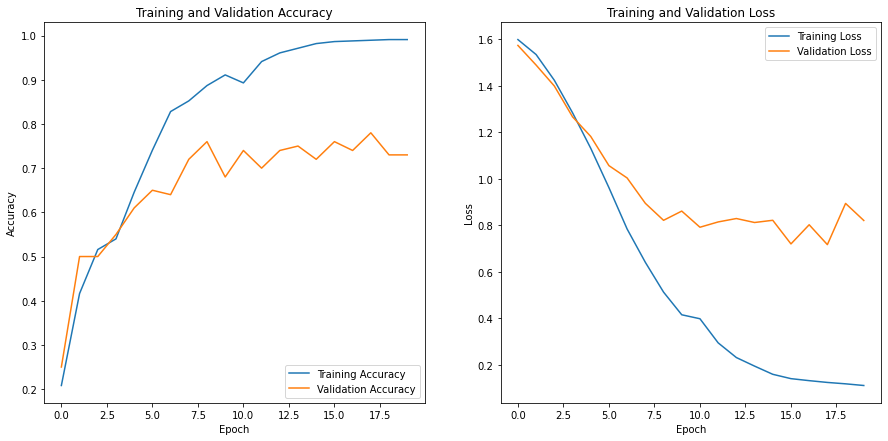

In [ ]:
plot(history_model7)

In [21]:
def cnn_lstm_gru(x,y,z, dropout):
    
  base_model = VGG16(include_top=False, weights='imagenet', input_shape=(y,z,3))
  a = base_model.output
  a = Flatten()(a)
  features = Dense(64, activation='relu')(a)
  conv_model = Model(inputs=base_model.input, outputs=features)
    
  for layer in base_model.layers:
      layer.trainable = False
        
  model = Sequential()
  model.add(TimeDistributed(conv_model, input_shape=(x,y,z,3)))
  model.add(LSTM(128, return_sequences=True))
  model.add(Dropout(dropout))
  model.add(GRU(64, return_sequences=True))
  model.add(Dropout(dropout))
  model.add(GRU(32))
 
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(dropout))
  model.add(Dense(5, activation='softmax'))
  return model

In [22]:
# Set the time to give unique filename to each checkpoint
curr_dt_time = datetime.datetime.now()
num_epochs = 20 # choose the number of epochs
batch_size = 32
img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29]
x=len(img_idx) # Number of images in sequence
y = 100
z = 100

# Set the training and validation data set path
train_path = '/datasets/Project_data/train'
val_path = '/datasets/Project_data/val'

# Set the Number of training and validation sequence in dataset
num_train_sequences = len(train_doc)
num_val_sequences = len(val_doc)

# Assign the number of steps per epoch for training and validation dataset
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [23]:
# Compile the conv3d_model
# Using Adam optimizer
adam = Adam(learning_rate=0.0001)
#adam = optimizers.Adam(learning_rate=0.0001)
model7_2 = cnn_lstm_gru(x,y,z,0.25)
model7_2.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model7_2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 18, 64)           15009664  
 ibuted)                                                         
                                                                 
 lstm (LSTM)                 (None, 18, 128)           98816     
                                                                 
 dropout_2 (Dropout)         (None, 18, 128)           0         
                                                                 
 gru (GRU)                   (None, 18, 64)            37248     
                                                                 
 dropout_3 (Dropout)         (None, 18, 64)            0         
                                                                 
 gru_1 (GRU)                 (None, 32)                9408      
                                                      

In [24]:
# Call the file path creating callback_dirctory function 
callbacks_list = callback_directory(curr_dt_time)

# Let us create the train_generator and the val_generator which will be used in .fit_generator.

normalise = lambda a: a/255.
train_generator = generator(train_path, train_doc, batch_size,y,z,normalise)
val_generator = generator(val_path, val_doc, batch_size,y,z,normalise)

In [25]:
#Fit the model
num_epochs=15
history_model7_2 = model7_2.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /datasets/Project_data/train ; batch size = 32 ;Image resolution = (100,100)
Epoch 1/15


2024-05-02 11:23:53.614161: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


21/21 [==============================] - ETA: 0s - loss: 1.6188 - categorical_accuracy: 0.2097Source path =  /datasets/Project_data/val ; batch size = 32 ;Image resolution = (100,100)

Epoch 00001: val_loss improved from inf to 1.59289, saving model to model_init_2024-05-0211_23_27.071453/model-00001-1.61877-0.20965-1.59289-0.32000.h5
21/21 [==============================] - 54s 2s/step - loss: 1.6188 - categorical_accuracy: 0.2097 - val_loss: 1.5929 - val_categorical_accuracy: 0.3200 - lr: 1.0000e-04
Epoch 2/15
21/21 [==============================] - ETA: 0s - loss: 1.5769 - categorical_accuracy: 0.3002
Epoch 00002: val_loss improved from 1.59289 to 1.56707, saving model to model_init_2024-05-0211_23_27.071453/model-00002-1.57689-0.30015-1.56707-0.38000.h5
21/21 [==============================] - 43s 2s/step - loss: 1.5769 - categorical_accuracy: 0.3002 - val_loss: 1.5671 - val_categorical_accuracy: 0.3800 - lr: 1.0000e-04
Epoch 3/15
21/21 [==============================] - ETA: 0s -

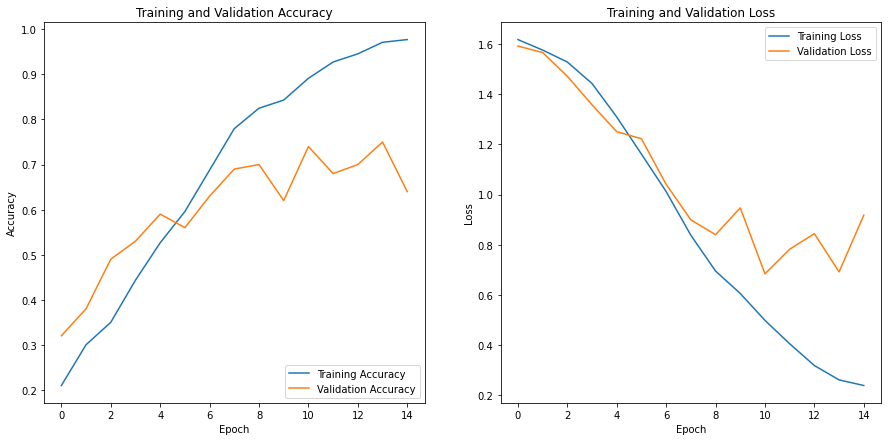

In [26]:
plot(history_model7_2)

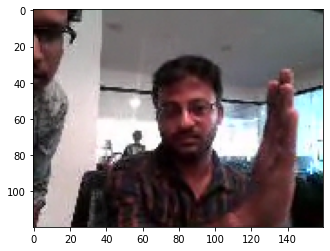

In [27]:
im = Image.open(folder_name + '/train/' + train_doc[0].split(';')[0] + '/' + imgs[0])
plt.imshow(im)

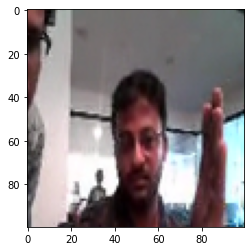

In [28]:
shifted = im.transform(im.size,Image.AFFINE,(1,0,np.random.randint(-30,30),0,1,np.random.randint(-30,30)))
gray = shifted.convert('L')
image = np.asarray(gray).astype(np.float32)
x0, y0 = np.argwhere(image > 0).min(axis=0)
x1, y1 = np.argwhere(image > 0).max(axis=0) 

cropped = shifted.crop((y0,x0,y1,x1))
im_resized = cropped.resize(size=(100,100))
plt.imshow(im_resized)

In [29]:
print(x0,y0,x1,y1)

28 0 119 152


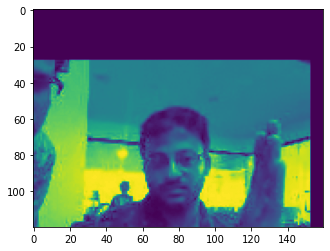

In [30]:
plt.imshow(gray)

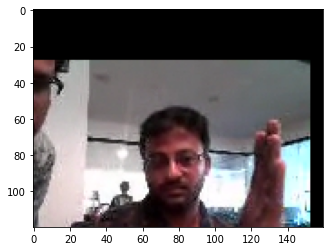

In [31]:
plt.imshow(shifted)

In [32]:
#Image Augmentation Function
def image_augment(image,y,z):
  shifted = image.transform(image.size,Image.AFFINE,(1,0,np.random.randint(-30,30),0,1,np.random.randint(-30,30)))
  gray = shifted.convert('L')
  im = np.asarray(gray).astype(np.float32)
  x0, y0 = np.argwhere(im > 0).min(axis=0)
  x1, y1 = np.argwhere(im > 0).max(axis=0) 

  cropped = shifted.crop((y0,x0,y1,x1))
  im_resized = np.asarray(cropped.resize(size=(y,z))).astype(np.float32)
  return(im_resized)

In [33]:
def generator_with_aug(source_path, folder_list, batch_size,y,z,normalise,augment = False):
    print( 'Source path = ', source_path, '; batch size =', batch_size,';Image resolution = ({},{})'.format(y,z))
    img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29] #create a list of image numbers you want to use for a particular video
    # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
    x=len(img_idx)
    while True:
        t = np.random.permutation(folder_list)
        num_batches =  int(len(t)/batch_size)  # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            
            # Newly added code for data augmentation 
            if(augment == True):
              batch_data_aug = np.zeros((batch_size,x,y,z,3)) # batch_data_aug is used to store the augmented data
            
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = Image.open(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item])
                    
                    # Newly added code for data augmentation(Translate the image randomly, crop and resize )
                    if( augment == True):
                      im_aug = image_augment(image,y,z)

                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes

                    if(image.size[0] == 160): # crop the image of shape 120 X 160 to make it  120 X120
                      image = image.crop((20,0,140,120)) # left =20, top =0, right = 140, bottom = 120
                    
                    image = image.resize(size = (y,z)) #imageio.imresize(image,(y,z)).astype(np.float32)
                    image = np.asarray(image).astype(np.float32)

                    batch_data[folder,idx,:,:,0] = normalise(image[:,:,0])  #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = normalise(image[:,:,1]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = normalise(image[:,:,2]) #normalise and feed in the image

                    #Newly added code( Normalise the augmented image data)
                    if(augment == True):
                      batch_data_aug[folder,idx,:,:,0] = normalise(im_aug[:,:,0])
                      batch_data_aug[folder,idx,:,:,1] = normalise(im_aug[:,:,1])
                      batch_data_aug[folder,idx,:,:,2] = normalise(im_aug[:,:,2])
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1

                
            # Newly added code(Concatinate the augmented data to the batch_data and their corresponding batch_labels
            if(augment == True):
              batch_data=np.concatenate([batch_data,batch_data_aug])
              batch_labels=np.concatenate([batch_labels,batch_labels])

            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches

        if (len(t) % batch_size) != 0:
          batch_data = np.zeros((len(t)%batch_size,x,y,z,3))
          batch_labels = np.zeros((len(t)%batch_size,5))
          if(augment == True):
             batch_data_aug = np.zeros((len(t)%batch_size,x,y,z,3)) # batch_data_aug is used to store the augmented data

          for folder in range(len(t)%batch_size):
            imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
            for idx,item in enumerate(img_idx):
              image = Image.open(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item])
                    
              # Newly added code for data augmentation(Translate the image randomly, crop and resize )
              if(augment==True):
                im_aug = image_augment(image,y,z)

              if image.size[0] == 160:
                image = image.crop((20,0,140,120)) # left =20, top =0, right = 140, bottom = 120
                                       
              image = image.resize(size = (y,z)) 
              image = np.asarray(image).astype(np.float32)

                    
              batch_data[folder,idx,:,:,0] = normalise(image[:,:,0])  #normalise and feed in the image
              batch_data[folder,idx,:,:,1] = normalise(image[:,:,1]) #normalise and feed in the image
              batch_data[folder,idx,:,:,2] = normalise(image[:,:,2]) #normalise and feed in the image

              #Newly added code( Normalise the augmented image data)
              if(augment == True):
                batch_data_aug[folder,idx,:,:,0] = normalise(im_aug[:,:,0])
                batch_data_aug[folder,idx,:,:,1] = normalise(im_aug[:,:,1])
                batch_data_aug[folder,idx,:,:,2] = normalise(im_aug[:,:,2])

            batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

          #Newly added code(Concatinate the augmented data to the batch_data and their corresponding batch_labels
          if(augment==True):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

          yield batch_data, batch_labels

In [34]:
def Conv3dArchitecture(x,y,z):
  conv3d_model = Sequential()
  conv3d_model.add(Conv3D(64, (3,3,3), strides=(1,1,1), padding='same', input_shape=(x,y,z,3)))
  conv3d_model.add(BatchNormalization())
  conv3d_model.add(Activation('relu'))
  conv3d_model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

  conv3d_model.add(Conv3D(128, (3,3,3), strides=(1,1,1), padding='same'))
  conv3d_model.add(BatchNormalization())
  conv3d_model.add(Activation('relu'))
  conv3d_model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))


  conv3d_model.add(Conv3D(256, (3,3,3), strides=(1,1,1), padding='same'))
  conv3d_model.add(BatchNormalization())
  conv3d_model.add(Activation('relu'))
  conv3d_model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))


  conv3d_model.add(Conv3D(256, (3,3,3), strides=(1,1,1), padding='same'))
  conv3d_model.add(BatchNormalization())
  conv3d_model.add(Activation('relu'))
  conv3d_model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

  conv3d_model.add(Flatten())
  conv3d_model.add(Dropout(0.5))
  conv3d_model.add(Dense(512, activation='relu'))
  conv3d_model.add(Dropout(0.5))
  conv3d_model.add(Dense(5, activation='softmax'))
  return conv3d_model

In [35]:
# Set the time to give unique filename to each checkpoint
curr_dt_time = datetime.datetime.now()

num_epochs = 20 # choose the number of epochs
batch_size = 20

# Set the training and validation data set path
train_path = '/datasets/Project_data/train'
val_path = '/datasets/Project_data/val'

# Set the Number of training and validation sequence in dataset
num_train_sequences = len(train_doc)
num_val_sequences = len(val_doc)

img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29]
x=len(img_idx) # Number of images in sequence
y = 100
z = 100

In [36]:
# Compile the conv3d_model
# Using sgd optimizer
#sgd = optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.7, nesterov=True)
sgd = tf.keras.optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.7, nesterov=True)

conv3d_model1 = Conv3dArchitecture(x,y,z)
conv3d_model1.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(conv3d_model1.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 18, 100, 100, 64)  5248      
                                                                 
 batch_normalization_4 (Batc  (None, 18, 100, 100, 64)  256      
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 18, 100, 100, 64)  0         
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 9, 50, 50, 64)    0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 9, 50, 50, 128)    221312    
                                                                 
 batch_normalization_5 (Batc  (None, 9, 50, 50, 128)  

In [37]:
# Call the file path creating callback_dirctory function 
callbacks_list = callback_directory(curr_dt_time)

# Assign the number of steps per epoch for training and validation dataset
# The generator will creates batch_size * 2 data {(raw_data) + (augmented_data)} for one batch
# But number of steps per epoch is same but for each batch number of samples increased

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size) 
else:
    steps_per_epoch = (num_train_sequences//batch_size ) + 1 
# batch size of validation data should be   
if (num_val_sequences%(batch_size)) == 0:
    validation_steps = int(num_val_sequences/(batch_size))
else:
    validation_steps = (num_val_sequences//(batch_size)) + 1


# Let us create the train_generator and the val_generator which will be used in .fit_generator.

normalise = lambda a: a/255.
train_generator = generator_with_aug(train_path, train_doc, batch_size,y,z,normalise,augment=True)
val_generator = generator_with_aug(val_path, val_doc, batch_size,y,z,normalise)

#Fit the model
history_model1 = conv3d_model1.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)



Source path =  /datasets/Project_data/train ; batch size = 20 ;Image resolution = (100,100)
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 2.6660 - categorical_accuracy: 0.3198Source path =  /datasets/Project_data/val ; batch size = 20 ;Image resolution = (100,100)

Epoch 00001: val_loss improved from inf to 1.63910, saving model to model_init_2024-05-0211_34_19.274432/model-00001-2.66597-0.31976-1.63910-0.20000.h5
34/34 [==============================] - 76s 2s/step - loss: 2.6660 - categorical_accuracy: 0.3198 - val_loss: 1.6391 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.5736 - categorical_accuracy: 0.4133
Epoch 00002: val_loss did not improve from 1.63910
34/34 [==============================] - 70s 2s/step - loss: 1.5736 - categorical_accuracy: 0.4133 - val_loss: 2.0546 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 1.3

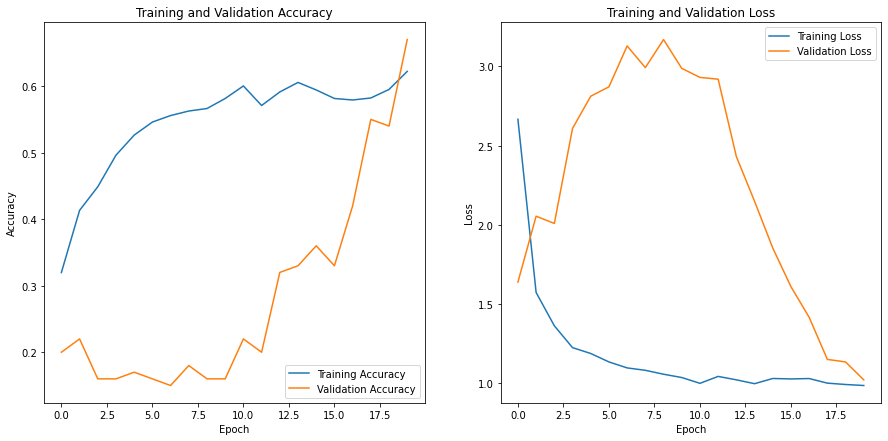

In [38]:
plot(history_model1)

In [39]:
def cnn_lstm_gru(x,y,z, dropout):
    
  base_model = VGG16(include_top=False, weights='imagenet', input_shape=(y,z,3))
  a = base_model.output
  a = Flatten()(a)
  features = Dense(64, activation='relu')(a)
  conv_model = Model(inputs=base_model.input, outputs=features)
    
  for layer in base_model.layers:
      layer.trainable = False
        
  model = Sequential()
  model.add(TimeDistributed(conv_model, input_shape=(x,y,z,3)))
  model.add(LSTM(128, return_sequences=True))
  model.add(Dropout(dropout))
  model.add(GRU(64, return_sequences=True))
  model.add(Dropout(dropout))
  model.add(GRU(32))
 
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(dropout))
  model.add(Dense(5, activation='softmax'))
  return model


In [40]:
# Set the time to give unique filename to each checkpoint
curr_dt_time = datetime.datetime.now()
num_epochs = 20 # choose the number of epochs
batch_size = 32
img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29]
x=len(img_idx) # Number of images in sequence
y = 100
z = 100

# Set the training and validation data set path
train_path = '/datasets/Project_data/train'
val_path = '/datasets/Project_data/val'

# Set the Number of training and validation sequence in dataset
num_train_sequences = len(train_doc)
num_val_sequences = len(val_doc)

# Assign the number of steps per epoch for training and validation dataset
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [41]:
# Compile the conv3d_model
# Using Adam optimizer
adam = Adam(learning_rate=0.0001)
#adam = optimizers.Adam(learning_rate=0.0001)
model9 = cnn_lstm_gru(x,y,z,0.25)
model9.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model9.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_1 (TimeDis  (None, 18, 64)           15009664  
 tributed)                                                       
                                                                 
 lstm_1 (LSTM)               (None, 18, 128)           98816     
                                                                 
 dropout_7 (Dropout)         (None, 18, 128)           0         
                                                                 
 gru_2 (GRU)                 (None, 18, 64)            37248     
                                                                 
 dropout_8 (Dropout)         (None, 18, 64)            0         
                                                                 
 gru_3 (GRU)                 (None, 32)                9408      
                                                      

In [42]:
# Call the file path creating callback_dirctory function 
callbacks_list = callback_directory(curr_dt_time)

# Let us create the train_generator and the val_generator which will be used in .fit_generator.

normalise = lambda a: a/255.
train_generator = generator_with_aug(train_path, train_doc, batch_size,y,z,normalise, True)
val_generator = generator_with_aug(val_path, val_doc, batch_size,y,z,normalise)

In [43]:
#Fit the model

history_model9 = model9.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /datasets/Project_data/train ; batch size = 32 ;Image resolution = (100,100)
Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 1.6111 - categorical_accuracy: 0.2044Source path =  /datasets/Project_data/val ; batch size = 32 ;Image resolution = (100,100)

Epoch 00001: val_loss improved from inf to 1.58545, saving model to model_init_2024-05-0211_59_01.759707/model-00001-1.61112-0.20437-1.58545-0.22000.h5
21/21 [==============================] - 83s 4s/step - loss: 1.6111 - categorical_accuracy: 0.2044 - val_loss: 1.5855 - val_categorical_accuracy: 0.2200 - lr: 1.0000e-04
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.5632 - categorical_accuracy: 0.3281
Epoch 00002: val_loss improved from 1.58545 to 1.53043, saving model to model_init_2024-05-0211_59_01.759707/model-00002-1.56316-0.32805-1.53043-0.40000.h5
21/21 [==============================] - 72s 4s/step - loss: 1.5632 - categorical_accuracy: 0.3281 - val_loss: 1.5304 - val_cate

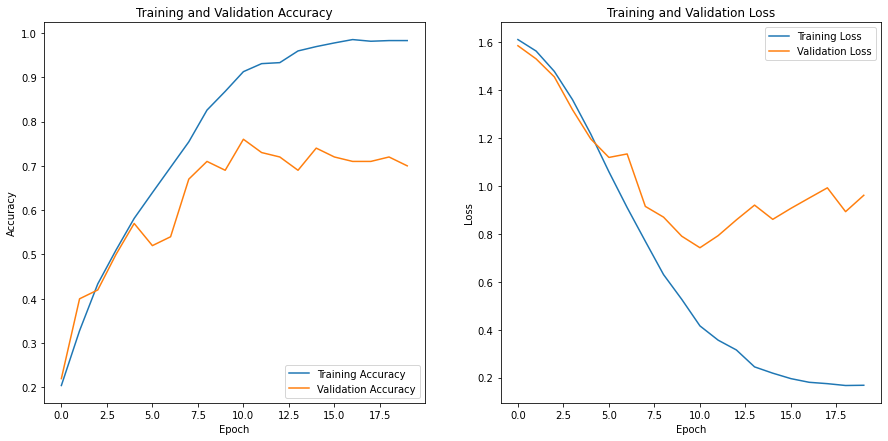

In [44]:
plot(history_model9)

In [45]:
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

In [46]:
def cnn_gru(x,y,z,dropout):
  model = Sequential()
  model.add(TimeDistributed(mobilenet_transfer,input_shape=(x,y,z,3)))

  model.add(TimeDistributed(BatchNormalization()))
  model.add(TimeDistributed(MaxPooling2D((2, 2))))
  model.add(TimeDistributed(Flatten()))

  model.add(GRU(128))
  model.add(Dropout(dropout))
    
  model.add(Dense(128,activation='relu'))
  model.add(Dropout(dropout))
    
  model.add(Dense(5, activation='softmax'))
  return model

In [55]:
#gc.collect() 
K.clear_session()

In [56]:
# Set the time to give unique filename to each checkpoint
curr_dt_time = datetime.datetime.now()
num_epochs = 20 # choose the number of epochs
batch_size = 32
img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29]
x=len(img_idx) # Number of images in sequence
y = 100
z = 100

# Set the training and validation data set path
train_path = '/datasets/Project_data/train'
val_path = '/datasets/Project_data/val'

# Set the Number of training and validation sequence in dataset
num_train_sequences = len(train_doc)
num_val_sequences = len(val_doc)

# Assign the number of steps per epoch for training and validation dataset
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [57]:
# Compile the conv3d_model
# Using Adam optimizer
adam = Adam(learning_rate=0.0001)
#adam = optimizers.Adam(learning_rate=0.0001)
model10 = cnn_gru(x,y,z,0.25)
model10.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model10.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 18, 3, 3, 1024)   3228864   
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 18, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 18, 1, 1, 1024)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 18, 1024)         0         
 tributed)                                                       
                                                                 
 gru (GRU)                   (None, 128)               4

In [58]:
# Call the file path creating callback_dirctory function 
callbacks_list = callback_directory(curr_dt_time)

# Let us create the train_generator and the val_generator which will be used in .fit_generator.

normalise = lambda a: a/255.
train_generator = generator_with_aug(train_path, train_doc, batch_size,y,z,normalise, True)
val_generator = generator_with_aug(val_path, val_doc, batch_size,y,z,normalise)

In [59]:
#Fit the model
history_model10 = model10.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /datasets/Project_data/train ; batch size = 32 ;Image resolution = (100,100)
Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 1.4568 - categorical_accuracy: 0.3854Source path =  /datasets/Project_data/val ; batch size = 32 ;Image resolution = (100,100)

Epoch 00001: val_loss improved from inf to 1.08048, saving model to model_init_2024-05-0212_40_12.829792/model-00001-1.45682-0.38537-1.08048-0.63000.h5
21/21 [==============================] - 77s 4s/step - loss: 1.4568 - categorical_accuracy: 0.3854 - val_loss: 1.0805 - val_categorical_accuracy: 0.6300 - lr: 1.0000e-04
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 0.8380 - categorical_accuracy: 0.7104
Epoch 00002: val_loss improved from 1.08048 to 0.79452, saving model to model_init_2024-05-0212_40_12.829792/model-00002-0.83799-0.71041-0.79452-0.69000.h5
21/21 [==============================] - 71s 4s/step - loss: 0.8380 - categorical_accuracy: 0.7104 - val_loss: 0.7945 - val_cate

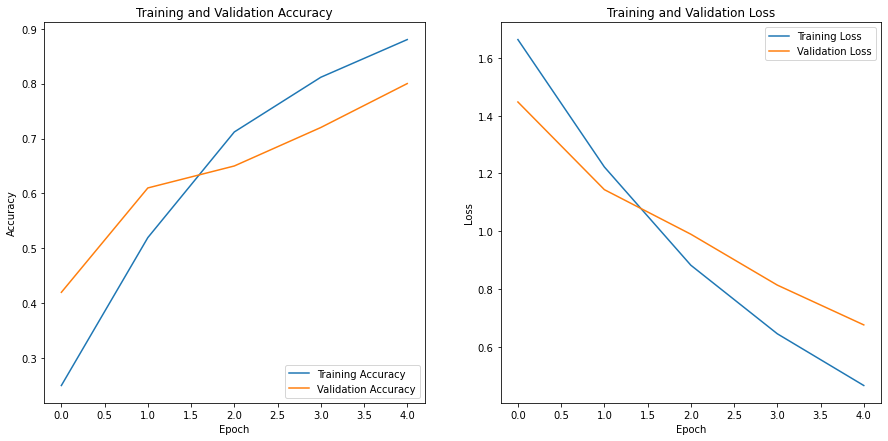

In [51]:
plot(history_model10)